<a href="https://colab.research.google.com/github/dschlesinger/experiments/blob/main/fibonnaci/Fibonnaci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is the Fibonnaci Sequence?

The fibonnaci of a number **n** is F(**n**) = F(**n** - 1) + F(**n** - 2)

Starting with the F(**0**) = 0 and the F(**1**) = 1

So it goes somthing like

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, ...]

<br>

### Sections in descending run time order
- Recursive - The Common Approach = O(2<sup>**n**</sup>)
- Recursive + Caching - Smarter = O(**n**)
- Dynamic Programming - The Cool Way = O(**n**)
- Matrix Multplication - The Hacker Way = O(log(**n**))
- Fast Doubling - The Math Way Part 1 = O(log(**n**))
- Binet's Formula - The Math Way Part 2 = O(1)

### Utils

In [112]:
import numpy as np, matplotlib.pyplot as plt, math

from tqdm import tqdm

from timeit import timeit

from typing import *

def graph_time(fn: Callable, tests: Iterable, clear_cache: bool = False) -> Tuple:

  times = []

  # Gather data
  for t in tqdm(tests):

    times.append(timeit(lambda: fn(t), number=1))

    # For cached recursive so F(n) does not effect F(n+1)
    if clear_cache: fn.cache_clear()

  times = np.array(times)

  # Smooth Graph

  kernel = np.full(shape=(times.shape[0] // 10,), fill_value = 1 / times.shape[0])

  smoothed = np.convolve(times, kernel, mode='same')

  # Cap at 2 stds

  smoothed[np.abs((smoothed - smoothed.mean())) > 2 * smoothed.std()] = smoothed.mean()

  plt.plot(tests, smoothed)

  return tests, smoothed

def fit_poly(deg: int, tests, times) -> None:
  """Tries a degree fit for runtime"""

  times = np.array(times)
  tests = np.array(tests)

  coeffs = np.polyfit(tests, times, deg=deg)

  pred = np.polyval(coeffs, tests)

  mse = np.mean((times - pred) ** 2)

  plt.plot(tests, pred)

  print(f"""
  Polynomial (deg = {deg})
  Coeffs: {coeffs}
  MSE ({mse})
  """)

import numpy as np
import matplotlib.pyplot as plt

def fit_log(tests, times):
    """Fits log model no bias"""
    tests = np.array(tests)
    times = np.array(times)

    logx = np.log2(tests + np.finfo(float).eps)[:, np.newaxis]

    coeff, *_ = np.linalg.lstsq(logx, times, rcond=None)

    pred = logx @ coeff
    mse = np.mean((times - pred) ** 2)

    # Clip to get nice plot
    plt.plot(tests, np.clip(pred, times.min() * 0.95, times.max() * 1.05))

    print(f"""
    log2 Fit (No Bias)
    Coeff: a = {coeff[0]}
    MSE: {mse}
    """)

def graph_error(fn: Callable, ref_fn: Callable, r: Iterable) -> None:
  """Graph diffrence between fn and refrence function"""

  error = np.abs(
      np.array(
          [fn(i) - ref_fn(i) for i in r]
      )
  )

  plt.plot(r, error)

### Recursive

In [113]:
def fibonnaci_recursive(n: int) -> int:
  """Calculates the fibonnaci of a number recursively

  Args:
    n: int - n > -1
  """

  if n < 2:
    return n

  return fibonnaci_recursive(n - 1) + fibonnaci_recursive(n - 2)

100%|██████████| 36/36 [00:05<00:00,  6.22it/s] 


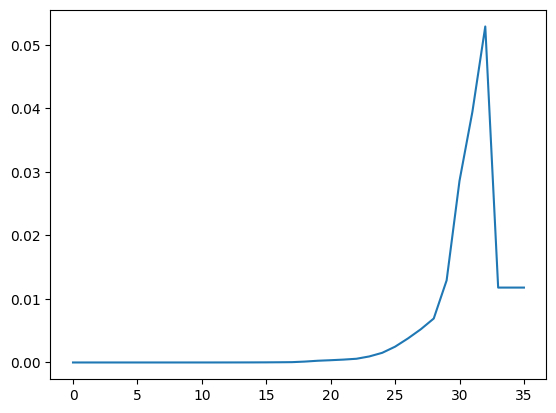

In [114]:
# Anything > 36 takes forever
tests, times = graph_time(fibonnaci_recursive, range(36))

Runtime Analysis: O(2<sup>**n**</sup>) <br>
Space Analysis: O(1) # As we recompute

### Recursive + Caching

In [115]:
# Use python's built in caching

from functools import cache

# Just wrap our original function
@cache
def fibonnaci_cache(n: int) -> int:
  """Calculates the fibonnaci of a number recursively, but cached

  Args:
    n: int - n > -1
  """

  if n < 2:
    return n

  return fibonnaci_cache(n - 1) + fibonnaci_cache(n - 2)

100%|██████████| 1000/1000 [00:01<00:00, 735.51it/s]



  Polynomial (deg = 1)
  Coeffs: [5.42663984e-08 5.67521121e-05]
  MSE (1.185488025818159e-09)
  


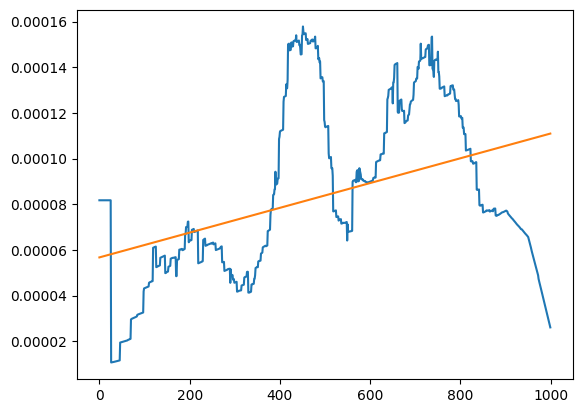

In [120]:
# Stress test and find runtime complexity
tests, time = graph_time(fibonnaci_cache, range(int(1e3)), clear_cache=True)
fit_poly(1, tests, time)

Runtime Analysis: O(n) <br>
Space Analysis: O(n) # as we memorize everything
<br><br>
Note: Because we clear the cache between numbers it takes longer, if we didn't each sucsessive number would be O(1)

100%|██████████| 1000/1000 [00:00<00:00, 1815.30it/s]



  Polynomial (deg = 1)
  Coeffs: [-2.73788192e-10  5.25171146e-07]
  MSE (1.871676341487182e-13)
  


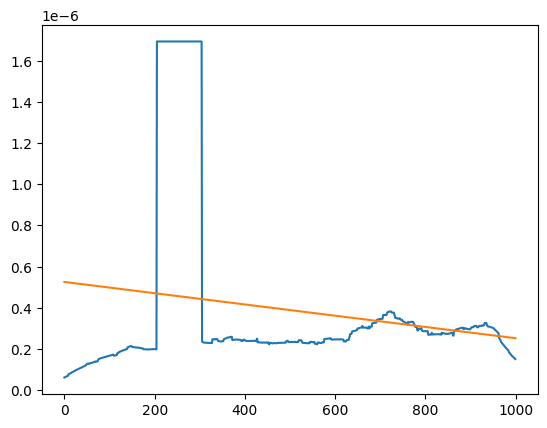

In [119]:
# Fun example if we dont clear the cache
tests, time = graph_time(fibonnaci_cache, range(int(1e3)), clear_cache=False)
fit_poly(1, tests, time)

Runtime Analysis: O(1) # For each sucsessive number <br>
Space Complexity: O(n)

### Dynamic Programming

In [121]:
def fibonnaci_dynamic_programming(n: int) -> int:
  """Uses sliding window approach"""

  if n < 1:

    return 0

  a, b = 0, 1

  for _ in range(n - 1):

    a, b = b, a + b

  return b


100%|██████████| 1000/1000 [00:00<00:00, 2883.32it/s]



  Polynomial (deg = 1)
  Coeffs: [ 2.06833372e-08 -1.24394112e-06]
  MSE (2.049940549753308e-11)
  


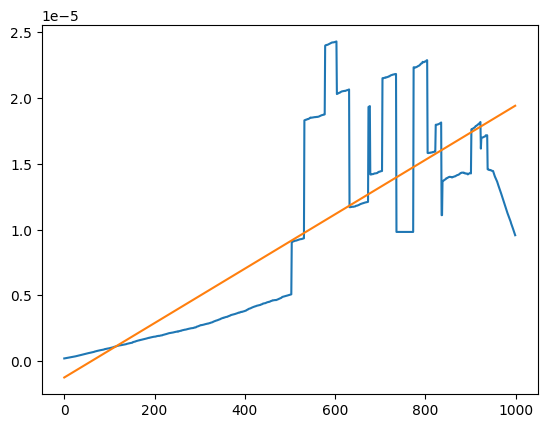

In [123]:
# Stress test and find runtime complexity
tests, time = graph_time(fibonnaci_dynamic_programming, range(int(1e3)))
fit_poly(1, tests, time)

Runtime Analysis: O(n) <br>
Space Analysis: O(1) # As we only memorize F(n-2) and F(n-1)

### Matrix Multplication

While this method requires more computation then dynamic programming it can be parrelized using exponentiation by squaring

In [125]:
def fibonnaci_matrix(n: int) -> int:
  """Uses Exponential Squaring for Parallel Processing"""

  if n < 1:
    return 0

  # Construct A
  """Structure of final A ^ n
  [F(n+1), F(n)]
  [F(n), F(n-1)]

  as F(n+2) = F(n+1) * 1 + F(n) * 1
  as F(n+1) = F(n+1) * 1 + F(n) * 0
  as F(n) = F(n+1) * 0 + F(n) * 1

  we multiply by
  [1, 1]
  [1, 0]

  """
  A = np.array([
      [1, 1],
      [1, 0],
  ], dtype=np.long)

  # Uses exponentiation by squaring
  F = np.linalg.matrix_power(A, n - 1)

  return F[0, 0].item()

100%|██████████| 100000/100000 [00:13<00:00, 7421.54it/s]



    log2 Fit (No Bias)
    Coeff: a = 3.354254329167248e-07
    MSE: 6.227100551501714e-13
    


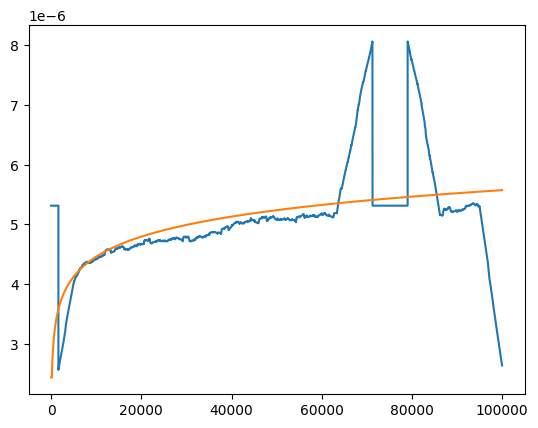

In [126]:
# Warm up
_ = np.linalg.matrix_power(np.random.randint(-10, 10, size=(3,3)), 1000)

# Stress test and find runtime complexity, takes about 15 seconds
tests, times = graph_time(fibonnaci_matrix, range(int(1e5)))
fit_log(tests, times)

Runtime Analysis: O(log(n)) <br>
Space Analysis: O(log(n)) # As all squares for layer the same only 1 matrix per layer

In [127]:
# Problem :( due to fixed sized types overflows
fibonnaci_matrix(int(1e6))

-4249520595888827205

### Fast Doubling

#### Proof
**Given that**
<br>
F(n+1) = F(n) + F(n-1)
<br><br>
F(2n) = F(n)*F(n+1) + F(n)F(n-1)
<br>
F(2n+1) = F(n+1)<sup>2</sup>+F(n)<sup>2</sup>
<br><br>
F(2n) = F(n) * (2F(n+1)-F(n))
<br>
F(2n+1) = F(n)<sup>2</sup> + F(n-1)<sup>2</sup>
<br>


[Article](https://iorilan.medium.com/math-explained-to-programmers-the-fibonacci-sequence-using-fast-doubling-approach-cf173b359442)

If Number is odd use F(2n+1) else F(2n) identity

In [128]:
def fibonnaci_fast_double(n: int) -> int:
    def fib_descend(n: int) -> Tuple[int, int]:
        """Recursively Finds F(n // 2)"""

        if n <= 0:
            return (0, 1)
        else:
            a, b = fib_descend(n // 2) # Starts with F(n - 1), F(n)

            c = a * (2 * b - a)
            # c | F(2n) = F(n-1) (2F(n)-F(n-1))

            d = a * a + b * b
            # d | F(2n+1) = F(n-1) ** 2 + F(n) ** 2

            if n % 2 == 0:
                return (c, d) # (F(2n), F(2n+1))
            else:
                return (d, c + d) # (F(2n), F(2n) + F(2n - 1))

    return fib_descend(n)[0]

In [145]:
import sys
sys.set_int_max_str_digits(int(1e7))

num = 1e8

size_MB = sys.getsizeof(fibonnaci_fast_double(num)) / (1024 ** 2)

print(f"Fib of {num} is {size_MB:.2f}MB")

Fib of 100000000.0 is 8.83MB


100%|██████████| 1000/1000 [00:35<00:00, 27.80it/s]



    log2 Fit (No Bias)
    Coeff: a = 0.00018431763534934557
    MSE: 5.234747309613619e-06
    


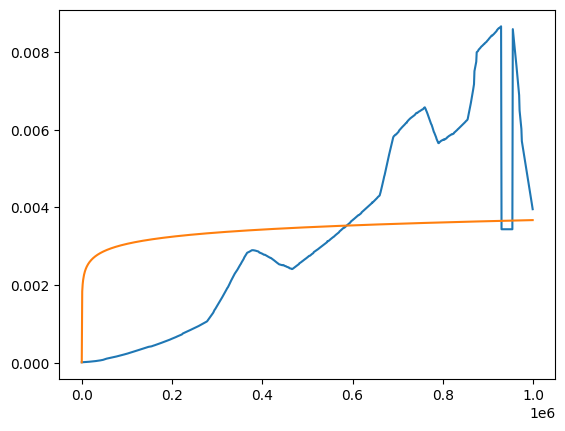

In [130]:
tests, times = graph_time(fibonnaci_fast_double, range(0, int(1e6), int(1e3)))
fit_log(tests, times)

Runtime Analysis: O(log(**n**)) # Should be Graph is linear? <br>
Space Analysis: O(1)

### Binet's Formula

#### Reasoning

[video](https://www.youtube.com/watch?v=ZiGW6PbB8wA)

As n → ∞ | F(n+1) / F(n) → Φ or the golden ratio <br>
Φ ≈ 1.618 <br>
<br>
We can predict F(n) using Φ<sup>**n**</sup> and the error of this is (1 - Φ)<sup>**n**</sup><br>
<br>
So F(n) = (Φ<sup>**n**</sup> - (1 - Φ)<sup>**n**</sup>) / sqrt(5)

In [131]:
def fibonnaci_binets(n: int) -> int:

  phi = (1 + np.sqrt(5)) / 2

  value = ((phi ** n) - ((1 - phi) ** n)) / np.sqrt(5)

  # Cannot convert infinity to int
  if math.isinf(value): return value

  return int(value)

  1%|▏         | 1437/100000 [00:00<00:06, 14362.93it/s]<ipython-input-131-fdf1259ff542>:5: RuntimeWarning: overflow encountered in scalar power
  value = ((phi ** n) - ((1 - phi) ** n)) / np.sqrt(5)
100%|██████████| 100000/100000 [00:08<00:00, 11444.26it/s]



  Polynomial (deg = 0)
  Coeffs: [1.12923737e-06]
  MSE (3.453791789207616e-14)
  


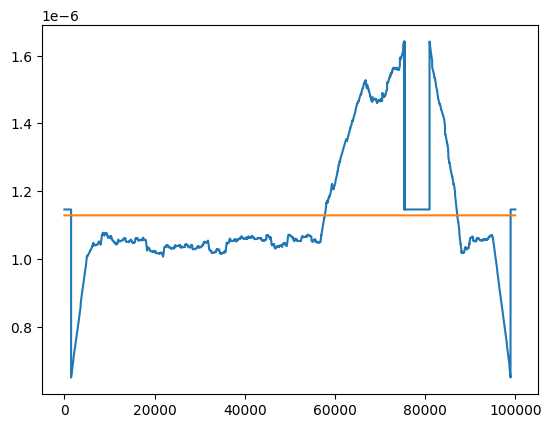

In [132]:
tests, times = graph_time(fibonnaci_binets, range(int(1e5)))
fit_poly(0, tests, times)

In [133]:
# Works for all i < 72
assert all([fibonnaci_binets(i) == fibonnaci_dynamic_programming(i) for i in range(72)])

In [134]:
# Doesn't work past 72
fibonnaci_binets(72) == fibonnaci_dynamic_programming(72)

False

Why? <br>
<br>
Because of Floating Point Errors as we take an irrantional number to an ever increasing power we loose information which leads to incorrect predictions

Lets Graph this error!

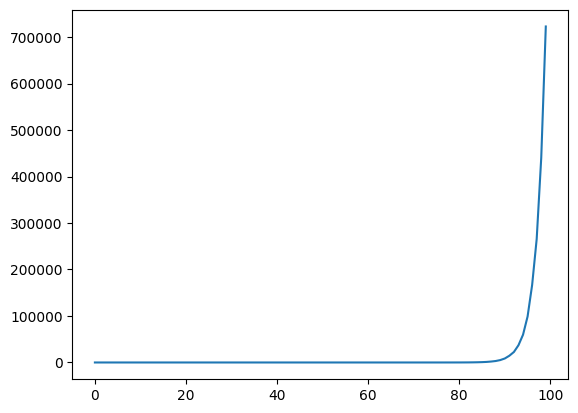

In [138]:
graph_error(fibonnaci_binets, fibonnaci_dynamic_programming, range(100))

Runtime Analysis: O(1) <br>
Usefulness Analysis: Not Very